# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an autoregressive model and run it on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code. It may take longer to run since we are using larger datasets.

In [1]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF" -O hw3_data.zip && rm -rf /tmp/cookies.txt
!unzip -qq hw3_data.zip -d deepul/homeworks/hw3/data
!rm hw3_data.zip
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 758 (delta 1), reused 0 (delta 0), pack-reused 749
Receiving objects: 100% (758/758), 117.08 MiB | 33.55 MiB/s, done.
Resolving deltas: 100% (346/346), done.
Checking out files: 100% (129/129), done.
--2020-12-09 23:13:22--  https://docs.google.com/uc?export=download&confirm=9qVo&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF
Resolving docs.google.com (docs.google.com)... 173.194.202.113, 173.194.202.101, 173.194.202.138, ...
Connecting to docs.google.com (docs.google.com)|173.194.202.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-1k-docs.googleusercontent.com/docs/securesc/uu58jqdnhila4ki92281ro9a3f7eq3bg/9fu4fp475qi9q8nd8cgguckqj14qhrig/1607555550000/06419056966375271799/15437805142923878269Z/1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF?e=download [following]
--2020-12-09 23:13

In [2]:
from deepul.hw3_helper import *

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.autonotebook import tqdm
from torch.optim import Adam
from torch.utils.data import DataLoader

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

# Question 3: VQ-VAE [40pts]
In this question, you with train a [VQ-VAE](https://arxiv.org/abs/1711.00937) on the colored shapes dataset and SVHN. If you are confused on how the VQ-VAE works, you may find [Lilian Weng's blogpost](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vq-vae-and-vq-vae-2) to be useful.

You may experiment with different hyperparameters and architecture designs, but the following designs for the VQ-VAE architecture may be useful.

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)

residual_block(dim)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 3, 1, 1)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 1, 1, 0)

Encoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)

Decoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32
```

A few other tips:
*   Use a codebook with $K = 128$ latents each with a $D = 256$ dimensional embedding vector
*   You should initialize each element in your $K\times D$ codebook to be uniformly random in $[-1/K, 1/K]$
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer
*   Center and scale your images to $[-1, 1]$
*   Supposing that $z_e(x)$ is the encoder output, and $z_q(x)$ is the quantized output using the codebook, you can implement the straight-through estimator as follows (where below is fed into the decoder): 
  * `(z_q(x) - z_e(x)).detach() + z_e(x)` in Pytorch
  * `tf.stop_gradient(z_q(x) - z_e(x)) + z_e(x)` in Tensorflow.

In addition to training the VQ-VAE, you will also need to train a PixelCNN prior on the categorical latents in order to sample. For your architecture, you may find the following useful:
*   Since the input is a 2D grid of discrete values, you should have an input (learned) embedding layer to map the discrete values to embeddings of length $64$
*   Use a single Type A masked convolutions followed by 10-15 residual blocks (same structure as HW 1), and $2$ $1\times 1$ convolutions of $512$ and $K$ channels respectively.
*   You may find normalization methods (e.g. BatchNorm, LayerNorm) to be useful
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer

**You will provide the following deliverables**


1.   Over the course of training, record the average loss of the training data (per minibatch) and test data (for your entire test set) **for both your VQ-VAE and PixelCNN prior**. Code is provided that automatically plots the training curves. 
2. Report the final test set performances of your final models
3. 100 samples from your trained VQ-VAE and PixelCNN prior
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)

## Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

###VQVAE

In [22]:
class Trainer:
    def __init__(self, model, train_loader, test_loader, num_epochs=10, lr=1e-2, clip_grad=1.):
        self.model = model
        self.optimizer = Adam(model.parameters(), lr)
        self.lr = lr
        self.clip_grad = clip_grad
        self.num_epochs = num_epochs
        self.train_loader = train_loader
        self.test_loader = test_loader

    def train(self):
        train_losses = []
        test_losses = [self.eval_epoch()]
        pbar = tqdm(range(self.num_epochs), total=self.num_epochs)
        for epoch in pbar:
            epoch_losses = self.train_epoch()
            train_losses.extend(epoch_losses)

            test_loss = self.eval_epoch()
            test_losses.append(test_loss)
            
            pbar.set_postfix_str(f'Epoch #{epoch}, test loss: {test_loss:.4f}')

        return train_losses, test_losses

    def train_epoch(self):
        self.model.train()
        
        train_losses = []
        for x in self.train_loader:
            loss = self.model.compute_loss(x.to(device).contiguous())
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_grad)
            self.optimizer.step()

            train_losses.append(loss.item())
        return train_losses

    def eval_epoch(self):
        self.model.eval()

        total_loss = 0
        with torch.no_grad():
            for x in self.test_loader:
                loss = self.model.compute_loss(x.to(device).contiguous())
                total_loss += loss * x.shape[0]

        return (total_loss / len(self.test_loader.dataset)).item()

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, dim_size=256):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(dim_size)
        self.conv1 = nn.Conv2d(dim_size, dim_size, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(dim_size)
        self.conv2 = nn.Conv2d(dim_size, dim_size, 1, 1, 0)
        self.relu = nn.ReLU()

    def forward(self, x):
        res = self.conv1(self.relu(self.bn1(x)))
        res = self.conv2(self.relu(self.bn2(res)))
        
        return res + x

In [7]:
class Encoder(nn.Module):
    def __init__(self, dim_size=256):
        super().__init__()
        self.conv1 = nn.Conv2d(3, dim_size, 4, 2, 1)
        self.bn = nn.BatchNorm2d(dim_size)
        self.conv2 = nn.Conv2d(dim_size, dim_size, 4, 2, 1)
        self.rb1  = ResidualBlock(dim_size)
        self.rb2  = ResidualBlock(dim_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn(self.conv1(x)))
        x = self.rb1(self.conv2(x))

        return self.rb2(x)

In [8]:
class Decoder(nn.Module):
    def __init__(self, dim_size=256):
        super().__init__()
        self.rb1  = ResidualBlock(dim_size)
        self.rb2  = ResidualBlock(dim_size)
        self.bn1 = nn.BatchNorm2d(dim_size)
        self.t_conv1 = nn.ConvTranspose2d(dim_size, dim_size, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(dim_size)
        self.t_conv2 = nn.ConvTranspose2d(dim_size, 3, 4, 2, 1)    
        self.relu = nn.ReLU()
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.rb1(x)
        x = self.rb2(x)
        x = self.t_conv1(self.bn1(self.relu(x)))
        x = self.t_conv2(self.bn2(self.relu(x)))

        return self.activation(x)

In [9]:
class CodeBook(nn.Module):
    def __init__(self, K=128, D=256):
        super().__init__()
        self.K = K
        self.D = D
        self.embedding = nn.Embedding(K, D)
        self.embedding.weight.data.uniform_(-1. / K, 1. / K)

    def forward(self, z):
        bs, c, h, w = z.shape
        flat_z = z.permute(0, 2, 3, 1).contiguous().view(-1, self.D)
        dist = torch.cdist(flat_z.unsqueeze(0), self.embedding.weight.unsqueeze(0)).squeeze()

        _, indices = torch.min(dist, dim=1)
        indices = indices.view(bs, h, w)
        emb = self.embedding(indices).permute(0, 3, 1, 2).contiguous()

        return emb, indices

In [10]:
class VQVAE(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.K = K
        self.D = D

        self.encoder = Encoder(D)
        self.decoder = Decoder(D)
        self.codebook = CodeBook(K, D)

    def forward(self, x):
        z = self.encoder(x)
        e, indices = self.codebook(z)
        x_recon = self.decoder((e - z).detach() + z)

        return x_recon, z, e

    def compute_loss(self, x):
        x_recon, z, e = self(x)

        vq_loss = F.mse_loss(z.detach(), e)
        cmt_loss = F.mse_loss(e.detach(), z)
        recon_loss = F.mse_loss(x, x_recon)

        return vq_loss + cmt_loss + recon_loss

    def encode(self, x):
        self.eval()

        res = []
        dataloader = DataLoader(x, batch_size=256)

        with torch.no_grad():
            for x in dataloader:
                x = x.float().to(device)
                z = self.encoder(x)
                e, indices = self.codebook(z)
                res.append(indices.long())

        return torch.cat(res)

    def decode(self, indices):
        self.eval()
        
        with torch.no_grad():
            e = self.codebook.embedding(indices).permute(0, 3, 1, 2)
            x = self.decoder(e)

        return x.permute(0, 2, 3, 1).cpu().detach().numpy()

###PixelCNN

In [27]:
class LayerNorm(nn.LayerNorm):
    def forward(self, x):
        x = super().forward(x.permute(0, 2, 3, 1).contiguous())
        return x.permute(0, 3, 1, 2).contiguous()

In [11]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        mask_type = kwargs.pop('mask_type', 'A')
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.init_mask(mask_type)

    def forward(self, x):
        return F.conv2d(x, 
                        self.weight * self.mask, 
                        self.bias, 
                        self.stride, 
                        self.padding, 
                        self.dilation,
                        self.groups)

    def init_mask(self, mask_type):
        h, w = self.kernel_size
        if mask_type == 'A':     
            self.mask[..., h // 2, :w // 2] = 1
            self.mask[..., :h // 2] = 1
        elif mask_type == 'B':
            self.mask[..., h // 2, :w // 2 + 1] = 1
            self.mask[..., :h // 2] = 1

In [26]:
class ResidualPixelCNN(nn.Module):
  def __init__(self, dim_size):
    super().__init__()
    self.ln1 = LayerNorm(dim_size)
    self.conv1 = MaskedConv2d(dim_size, dim_size//2, 1, mask_type='B')
    self.ln2 = LayerNorm(dim_size // 2)
    self.conv2 = MaskedConv2d(dim_size // 2, dim_size // 2, 3, 1, 1, mask_type='B')
    self.ln3 = LayerNorm(dim_size // 2)
    self.conv3 = MaskedConv2d(dim_size // 2, dim_size, 1, mask_type='B')
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.conv1(self.relu(self.ln1(x)))
    x = self.conv2(self.relu(self.ln2(x)))
    x = self.conv3(self.relu(self.ln3(x)))
    
    return x

In [14]:
class PixelCNN(nn.Module):
    def __init__(self, input_shape, K, D, num_blocks=10):
        super().__init__()
        self.input_shape = input_shape
        self.K = K
        self.D = D
        self.embedding = nn.Embedding(K, D)
        self.convA = MaskedConv2d(D, D, 7, 1, 3, mask_type='A')
        self.ln1 = LayerNorm(D)
        self.respixel_blocks = nn.ModuleList(
            [ResidualPixelCNN(D) for i in range(num_blocks)]
        ) 
        self.ln2 = LayerNorm(D)
        self.convB1 = MaskedConv2d(D, 2 * D, 1, mask_type='B')
        self.convB2 = MaskedConv2d(2 * D, K, 1, mask_type='B')
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.embedding(x).permute(0, 3, 1, 2).contiguous()
        x = self.convA(x)
        x = self.relu(self.ln1(x))
        
        for block in self.respixel_blocks:
            x = block(x)

        x = self.relu(self.ln2(x))
        x = self.relu(self.convB1(x))
        x = self.convB2(x)

        return x

    def compute_loss(self, x):
        res = self(x.long())
        return F.cross_entropy(res, x.long())

    def sample(self, n):
        self.eval()
        with torch.no_grad():
            samples = torch.zeros(n, *self.input_shape).to(device).long()
            num_x, num_y = self.input_shape
            for x in range(num_x):
                for y in range(num_y):
                    logits = self(samples)[:, :, x, y]
                    prob = F.softmax(logits, dim=1)
                    samples[:, x, y] = torch.multinomial(prob, 1)[...,0]

        return samples

In [23]:
def q3(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE train losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of PixelCNN prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of PixelCNN prior train losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """

    """ YOUR CODE HERE """

    train_data = (np.transpose(train_data, (0, 3, 1, 2)) / 255).astype('float32')
    test_data = (np.transpose(test_data, (0, 3, 1, 2)) / 255).astype('float32')
    K, D = 128, 256

    # VQVAE
    print('VQVAE', end='\n\n')

    train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=256)

    vqvae = VQVAE(K, D).to(device)
    trainer = Trainer(vqvae, train_loader, test_loader, 10, 1e-3)
    vq_train_losses, vq_test_losses = trainer.train()

    train_encoded = vqvae.encode(train_data)
    test_encoded  = vqvae.encode(test_data)

    # PixelCNN
    print('PixelCNN')

    prior_train_loader = DataLoader(train_encoded, batch_size=256, shuffle=True)
    prior_test_loader = DataLoader(test_encoded, batch_size=256)

    pixcnn = PixelCNN((8, 8), K, D).to(device)
    trainer = Trainer(pixcnn, prior_train_loader, prior_test_loader, 20, 1e-4)
    cnn_train_losses, cnn_test_losses = trainer.train()

    # samples
    samples = pixcnn.sample(100)
    samples = 255 * vqvae.decode(samples)
    
    # reconstruction
    x = test_data[:50]
    z = vqvae.encode(x)
    x_recon = vqvae.decode(z)
    x = x.transpose(0, 2, 3, 1)
    rec = np.stack((x, x_recon), axis=1).reshape((-1, 32, 32, 3)) * 255

    return vq_train_losses, vq_test_losses, cnn_train_losses, cnn_test_losses, samples, rec


## Results
Once you've finished `q3`, execute the cells below to visualize and save your results.

VQVAE




PixelCNN



VQ-VAE Final Test Loss: 0.0324
PixelCNN Prior Final Test Loss: 2.4447


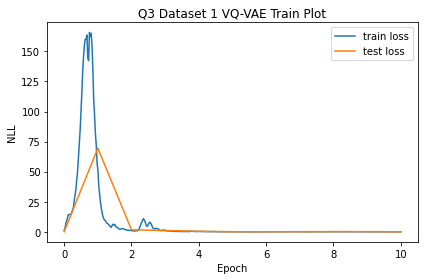

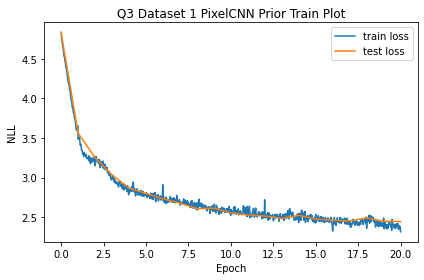

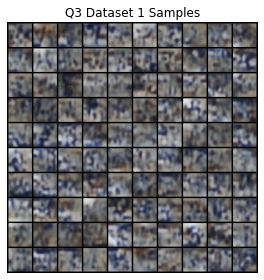

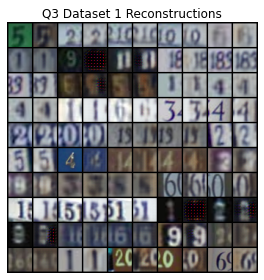

In [24]:
q3_save_results(1, q3)

VQVAE




PixelCNN



VQ-VAE Final Test Loss: 0.0145
PixelCNN Prior Final Test Loss: 2.8293


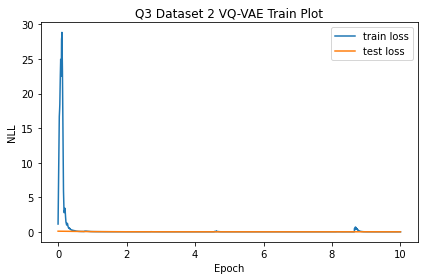

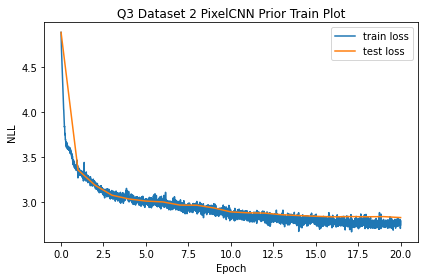

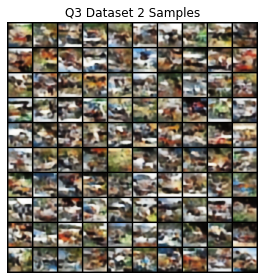

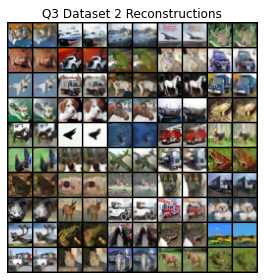

In [25]:
q3_save_results(2, q3)